# Crime Case Resolution Prediction Model


This machine learning project predicts the likelihood of a crime case being solved based on Los Angeles Police Department data. The model classifies cases into three categories: **Unsolved**, **Solved by Arrest**, and **Solved Exceptionally**.

## How to Run This Notebook

1. **Run All Cells Sequentially**: Click Runtime → Run all
2. **Or Run Section by Section**:
   - Start with Installation from the requirements.txt file then the Imports"
   - Then "Data Loading"
   - Continue through each section in order
3. **Ensure Dependencies**: All required packages are installed in the first cell

# Installation

In [10]:
!pip install -r requirements.txt

# Imports

In [12]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.cluster import KMeans

# Data Loading

In [18]:
#insure that this is the correct file path
data=pd.read_csv('data/Old_Crime_Data.csv')
print("Dataset shape:", data.shape)

# Initial data dolums
print("Columns:", data.columns.tolist())
print(data.info())
print(data.head())
for col in data.columns.tolist():
 print("Case status distribution:")
 print(data[col].value_counts())


Dataset shape: (1004991, 28)
Columns: ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1004991 non-null  int64  
 1   Date Rptd       1004991 non-null  object 
 2   DATE OCC        1004991 non-null  object 
 3   TIME OCC        1004991 non-null  int64  
 4   AREA            1004991 non-null  int64  
 5   AREA NAME       1004991 non-null  object 
 6   Rpt Dist No     1004991 non-null  int64  
 7   Part 1-2        1004991 non-null  int64  
 8   Crm Cd          1004991 non

# Data Preparation & Feature Engineering

In [20]:
print(data["Status Desc"].value_counts())
#simplifing the data , this column will be our Y variable instead of working with multiple values in Status desc
data['case_status'] = data['Status Desc'].apply(lambda x: 1 if x in ['Adult Arrest', 'Juv Arrest'] else 2 if x in [ 'Adult Other', 'Juv Other'] else 0)
print("Case status distribution:")
print(data["case_status"].value_counts())

#replaced the two date colum by calculating the time to report
#data["time_to_report"]=data.apply(lambda x :pd.to_datetime(x["Date Rptd"]) - pd.to_datetime(x["DATE OCC"]))
data['Date Rptd'] = pd.to_datetime(data['Date Rptd'])
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])
data["time_to_report"] = (data['Date Rptd'] - data['DATE OCC']).dt.total_seconds() / 3600


Status Desc
Invest Cont     802862
Adult Other     109802
Adult Arrest     87155
Juv Arrest        3286
Juv Other         1879
UNK                  7
Name: count, dtype: int64
Case status distribution:
case_status
0    802869
2    111681
1     90441
Name: count, dtype: int64


C:\Users\lenovo\AppData\Local\Temp\ipykernel_6464\8700629.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date Rptd'] = pd.to_datetime(data['Date Rptd'])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6464\8700629.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])


In [22]:
#Simplifying the case of multiple crimes by counting the crimes
data['crime_count'] = data[['Crm Cd', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']].notna().sum(axis=1)
#Deleting unnecessary columns
data=data.drop(columns=["DR_NO","Status","Date Rptd","Weapon Used Cd","DATE OCC","AREA NAME","Crm Cd Desc","Premis Desc","Weapon Desc","Status Desc","Cross Street","LOCATION", 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4'])
print(data['crime_count'].value_counts())


crime_count
2    935842
3     66835
4      2250
5        64
Name: count, dtype: int64


In [24]:
#Handling 0 and negative victim ages by calculating the median of the valid (non-null) values and assigning it to the invalid entriesdata['Vict_Age_Unknown_Flag'] = data['Vict Age'].apply(lambda x: 1 if x == 0 or x < 0 else 0)
data['Vict Age'] = data['Vict Age'].replace(0, np.nan)
data.loc[data['Vict Age'] < 0, 'Vict Age'] = np.nan
median_age = data['Vict Age'].median()
data['Vict Age'] = data['Vict Age'].fillna(median_age)
#print(data['Vict_Age_Unknown_Flag'].value_counts())

In [26]:
data.isnull().sum()
data.describe()

,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,LAT,LON,case_status,time_to_report,crime_count
count,1.004991e+06,1.004991e+06,1.004991e+06,1.004991e+06,1.004991e+06,1.004991e+06,1.004975e+06,1.004991e+06,1.004991e+06,1.004991e+06,1.004991e+06,1.004991e+06
mean,1.339900e+03,1.069174e+01,1.115633e+03,1.400348e+00,5.001568e+02,3.883403e+01,3.056201e+02,3.399821e+01,-1.180909e+02,3.122446e-01,2.922026e+02,2.071172e+00
std,6.510613e+02,6.110255e+00,6.111605e+02,4.899691e-01,2.052731e+02,1.336841e+01,2.193021e+02,1.610713e+00,5.582386e+00,6.610606e-01,1.659844e+03,2.663948e-01
min,1.000000e+00,1.000000e+00,1.010000e+02,1.000000e+00,1.100000e+02,2.000000e+00,1.010000e+02,0.000000e+00,-1.186676e+02,0.000000e+00,0.000000e+00,2.000000e+00
25%,9.000000e+02,5.000000e+00,5.870000e+02,1.000000e+00,3.310000e+02,3.100000e+01,1.010000e+02,3.401470e+01,-1.184305e+02,0.000000e+00,0.000000e+00,2.000000e+00
50%,1.420000e+03,1.100000e+01,1.139000e+03,1.000000e+00,4.420000e+02,3.700000e+01,2.030000e+02,3.405890e+01,-1.183225e+02,0.000000e+00,2.400000e+01,2.000000e+00
75%,1.900000e+03,1.600000e+01,1.613000e+03,2.000000e+00,6.260000e+02,4.400000e+01,5.010000e+02,3.416490e+01,-1.182739e+02,0.000000e+00,4.800000e+01,2.000000e+00
max,2.359000e+03,2.100000e+01,2.199000e+03,2.000000e+00,9.560000e+02,1.200000e+02,9.760000e+02,3.433430e+01,0.000000e+00,2.000000e+00,4.468800e+04,5.000000e+00


In [28]:
# Preprocess the Mocodes column
# Mocodes: Modus Operandi codes describing crime methodology
# Format: space-separated numeric codes (e.g., "0344 1822")
# Contains details about tools, methods, suspect behavior
# Multiple codes indicate complex crime circumstances
mocode_series = data['Mocodes'].fillna('')
data=data.drop(columns=["Mocodes"])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(mocode_series) # Learn the vocabulary from ALL data
sequences = tokenizer.texts_to_sequences(mocode_series)
# Converts variable-length MO code strings to fixed-length numerical sequences via padding/truncation
# Learns semantic relationships between codes through embedding layer before combining with other features
lengths = [len(seq) for seq in sequences]
max_len = int(np.percentile(lengths, 95)) # Pad to the 95th percentile length
mocode_padded = pad_sequences(sequences, maxlen=max_len, padding='pre', truncating='post')
print(mocode_padded)
# We will keep this 'mocode_padded' array to use later as a model input.

[[  0   0   0 ...   0   0  39]
 [  5  15  10 ...  44  78  64]
 [  0   0   0 ...   0   0  39]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...  61   1  86]
 [  0   0   0 ...  73 160   3]]


In [30]:
#FEATURE ENGENERING FOR THE CULUMS WITH MUSTIPLE STRING VALUES
data = pd.get_dummies(data, columns=['Vict Sex', 'Vict Descent', 'Premis Cd'], prefix_sep='_')


In [32]:
# CLUSTERING AND COMBINING THE LAT AND LOT IN ONE COLUMN

coords = data[['LAT', 'LON']].copy()

imputer = SimpleImputer(strategy='median')
coords_imputed = imputer.fit_transform(coords)
# Now perform clustering on the imputed coordinates
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
data['location_cluster'] = kmeans.fit_predict(coords_imputed)
data.drop(columns=['LAT', 'LON'], inplace=True)

In [36]:
#save the new processed data
print("Columns:", data.columns.tolist())
data.to_csv("data/proccessed_data.csv")

Columns: ['TIME OCC', 'AREA', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Vict Age', 'case_status', 'time_to_report', 'crime_count', 'Vict Sex_-', 'Vict Sex_F', 'Vict Sex_H', 'Vict Sex_M', 'Vict Sex_X', 'Vict Descent_-', 'Vict Descent_A', 'Vict Descent_B', 'Vict Descent_C', 'Vict Descent_D', 'Vict Descent_F', 'Vict Descent_G', 'Vict Descent_H', 'Vict Descent_I', 'Vict Descent_J', 'Vict Descent_K', 'Vict Descent_L', 'Vict Descent_O', 'Vict Descent_P', 'Vict Descent_S', 'Vict Descent_U', 'Vict Descent_V', 'Vict Descent_W', 'Vict Descent_X', 'Vict Descent_Z', 'Premis Cd_101.0', 'Premis Cd_102.0', 'Premis Cd_103.0', 'Premis Cd_104.0', 'Premis Cd_105.0', 'Premis Cd_106.0', 'Premis Cd_107.0', 'Premis Cd_108.0', 'Premis Cd_109.0', 'Premis Cd_110.0', 'Premis Cd_111.0', 'Premis Cd_112.0', 'Premis Cd_113.0', 'Premis Cd_114.0', 'Premis Cd_115.0', 'Premis Cd_116.0', 'Premis Cd_117.0', 'Premis Cd_118.0', 'Premis Cd_119.0', 'Premis Cd_120.0', 'Premis Cd_121.0', 'Premis Cd_122.0', 'Premis Cd_123.0', 'Premi

# Final Preparation

In [37]:
print("Creating MO code embeddings for the entire dataset...")
vocab_size = len(tokenizer.word_index) + 1

# here we going to use the mocode_padded we processed earlier
# Learns semantic relationships between codes through embedding layer before combining with other features
mocode_input = Input(shape=(max_len,), name='mocode_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=10, input_length=max_len)(mocode_input)
flatten_layer = Flatten()(embedding_layer)
embedding_model = Model(inputs=mocode_input, outputs=flatten_layer)
mo_embeddings = embedding_model.predict(mocode_padded, verbose=1, batch_size=1024)

# Add these embeddings as new columns to your main DataFrame

for i in range(mo_embeddings.shape[1]):
    data[f'mo_embedding_{i}'] = mo_embeddings[:, i]

print(f"Added {mo_embeddings.shape[1]} MO embedding columns to DataFrame")
print("New DataFrame shape:", data.shape)


Creating MO code embeddings for the entire dataset...


C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Added 70 MO embedding columns to DataFrame
New DataFrame shape: (1004991, 419)


# Train-Test Split

In [40]:
y = data['case_status']
X = data.drop(columns=['case_status'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_mo = mocode_padded[X_train.index]
X_test_mo = mocode_padded[X_test.index]

# Model Building & Training

In [42]:
# we handle the class embalence by calculating the weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.417250251961459, 1: 3.704025172879263, 2: 2.9995784132669243}


## Strategie 1 :

In [44]:
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

# Create sample weights
sample_weights = np.array([class_weights_dict[label] for label in y_train])

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

## Strategie 2 :

In [46]:
# Focus on parameters that control overfitting
xgb_model_tuned = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=4,  # Shallower trees to prevent overfitting
    learning_rate=0.05,  # Slower learning
    subsample=0.7,  # Use less data per tree
    colsample_bytree=0.7,  # Use fewer features per tree
    scale_pos_weight=class_weights_dict  # Use built-in balancing
)
# Create sample weights
sample_weights = np.array([class_weights_dict[label] for label in y_train])

xgb_model_tuned.fit(X_train, y_train, sample_weight=sample_weights)



C:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:37:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

## Strategie 3 :

In [47]:

# 1. Input for regular features
regular_input = Input(shape=(X_train.shape[1],), name='regular_input')

# 2. Input for MO sequences
mocode_input = Input(shape=(max_len,), name='mocode_input')
# added 1 to cover the 0 we added in the embedding
vocab_size = len(tokenizer.word_index) + 1
embedding = Embedding(input_dim=vocab_size, output_dim=10, input_length=max_len)(mocode_input)
flattened_embedding = Flatten()(embedding)

# 3. Combine both inputs
combined = Concatenate()([regular_input, flattened_embedding])

# 4. Classifier head
x = Dense(128, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x) # 3 output neurons for 3 classes

# 5. Create and compile model
model = Model(inputs=[regular_input, mocode_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(
    [X_train, X_train_mo], y_train,          # Training data: both inputs and target
    validation_data=([X_test, X_test_mo], y_test), # Validation data
    epochs=15,
    batch_size=256,
    class_weight=class_weights_dict          # Crucial for imbalanced data
)

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mocode_input (InputLayer)     │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 7, 10)             │           7,400 │ mocode_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ regular_input (InputLayer)    │ (None, 418)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 70)                │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 488)               │               0 │ regular_input[0][0],       │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          62,592 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 3)                 │             195 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 78,443 (306.42 KB)

 Trainable params: 78,443 (306.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.2025 - loss: 4.5867 - val_accuracy: 0.7989 - val_loss: 1.0951
Epoch 2/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.2096 - loss: 1.1003 - val_accuracy: 0.1111 - val_loss: 1.0947
Epoch 3/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.2398 - loss: 1.0999 - val_accuracy: 0.7989 - val_loss: 1.0918
Epoch 4/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5272 - loss: 1.0981 - val_accuracy: 0.0900 - val_loss: 1.1061
Epoch 5/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.3013 - loss: 1.0982 - val_accuracy: 0.7989 - val_loss: 1.0944
Epoch 6/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.3387 - loss: 1.0992 - val_accuracy: 0.0900 - val_loss: 1.0961
Epoch 7/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.2788 - loss: 1.0988 - val_accuracy: 0.1111 - val_loss: 1.1051
Epoch 8/15
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.2614 - loss: 1

# Evaluation

In [50]:
xgb_model
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred,
                           target_names=['Unsolved', 'Solved by Arrest', 'Solved Exceptionally']))

                      precision    recall  f1-score   support

            Unsolved       0.95      0.73      0.83    160575
    Solved by Arrest       0.27      0.50      0.35     18088
Solved Exceptionally       0.35      0.69      0.47     22336

            accuracy                           0.71    200999
           macro avg       0.52      0.64      0.55    200999
        weighted avg       0.82      0.71      0.75    200999



In [52]:
# Evaluate
y_pred = xgb_model_tuned.predict(X_test)
print(classification_report(y_test, y_pred,
                           target_names=['Unsolved', 'Solved by Arrest', 'Solved Exceptionally']))

                      precision    recall  f1-score   support

            Unsolved       0.95      0.72      0.82    160575
    Solved by Arrest       0.25      0.48      0.33     18088
Solved Exceptionally       0.34      0.69      0.45     22336

            accuracy                           0.69    200999
           macro avg       0.51      0.63      0.53    200999
        weighted avg       0.82      0.69      0.73    200999



In [54]:

# Get predictions for the test set
y_pred_probs = model.predict([X_test, X_test_mo])
y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class labels

# Generate the crucial report
print(classification_report(y_test, y_pred, target_names=['Unsolved', 'Solved by Arrest', 'Solved Exceptionally']))

6282/6282 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
                      precision    recall  f1-score   support

            Unsolved       0.80      1.00      0.89    160575
    Solved by Arrest       0.00      0.00      0.00     18088
Solved Exceptionally       0.00      0.00      0.00     22336

            accuracy                           0.80    200999
           macro avg       0.27      0.33      0.30    200999
        weighted avg       0.64      0.80      0.71    200999



C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After evaluating all three models, we selected the XGBoost model for deployment because it successfully predicts all three case resolution categories, unlike the neural network which completely failed on solved cases. It achieves the best balance of precision and recall, reliably identifying unsolved cases with 95% accuracy while still capturing 49-69% of solved cases. This provides a strong foundation for practical use in prioritizing investigable cases.

# Visualization:

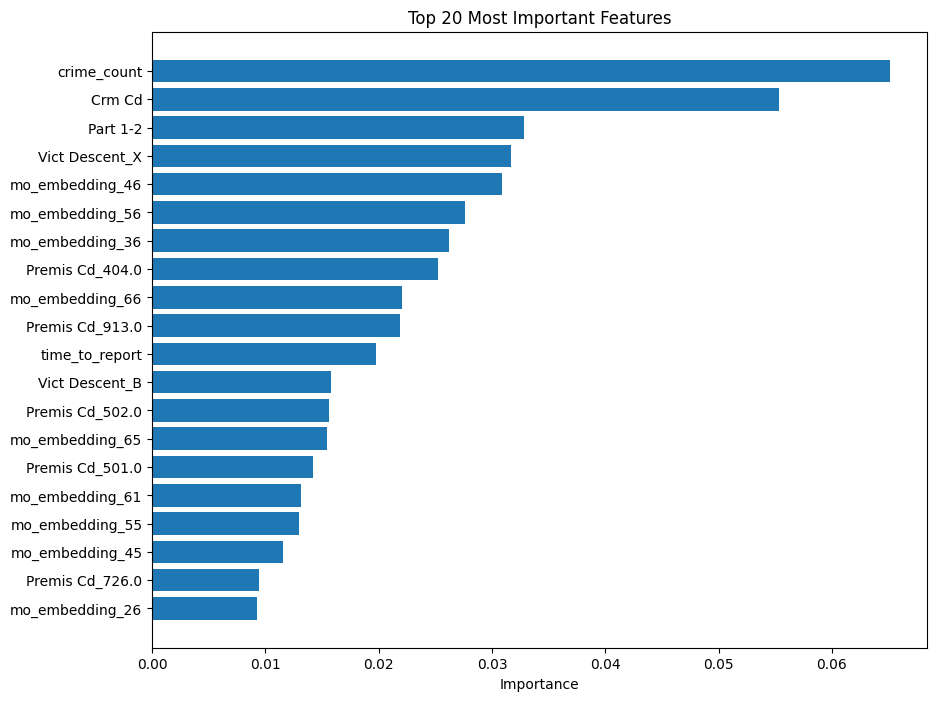

In [56]:
# Get feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame and sort
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
fi_df = fi_df.sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(fi_df['feature'][:20], fi_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.show()

# Save the model

In [64]:
joblib.dump(xgb_model, 'models/crime_prediction_model.pkl')

model.save("models/neural_network_model.keras")
#xgb_model.save_model('/models/crime_prediction_model.json')